## Домашняя работа к 4 уроку: "Алгоритм построения дерева решений"

Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

import random

from sklearn import datasets
from sklearn import model_selection

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

        
# Класс листа для регрессии        
class RegressionLeaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()        
        
    def predict(self):              
        prediction = np.mean(self.labels)        
        return prediction

# Класс дерева для регрессии
class RegressionTree:
    def __init__(self, max_leaf=100):
        self.max_leaf = max_leaf
        self.Node = None
    
    def variance(self, labels):
        return np.mean((labels - np.mean(labels))**2) 

    def quality(self, left_labels, right_labels, current_informations):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_informations - p * self.variance(left_labels) - (1 - p) * self.variance(right_labels)

    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):

        current_informations = self.variance(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                if len(true_data) < self.max_leaf or len(false_data) < self.max_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_informations)

                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)

        if quality == 0:
            return RegressionLeaf(data, labels)
        

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        if isinstance(node, RegressionLeaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
        
    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.Node)
            classes.append(prediction)
        return np.array(classes)

    def fit(self, train_data, train_labels):
        self.Node = self.build_tree(train_data, train_labels)
        
def R2(act, pred):
    S_total = ((act - np.mean(act))**2).sum()
    S_res = ((act - pred)**2).sum()
    return 1 - S_res / S_total

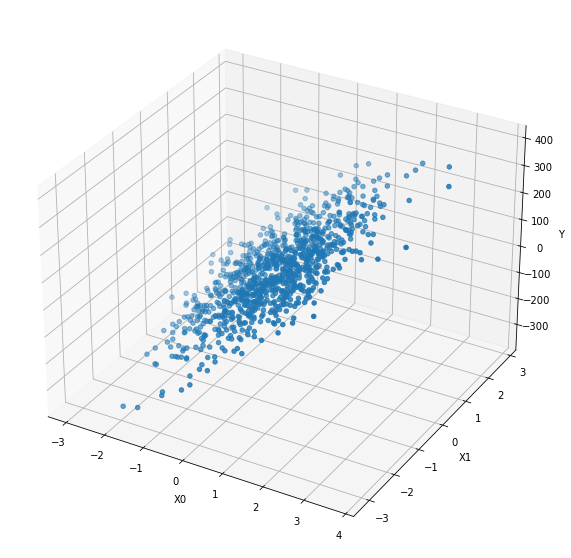

In [3]:
# сгенерируем набор данных
X, y = datasets.make_regression(n_samples=1000, n_features=2, n_targets=1, random_state=3)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], y)

ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('Y')
plt.show()

In [4]:
tree = RegressionTree()
tree.fit(X_train, y_train)
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)


R2_train = R2(y_train, y_pred_train)
R2_test = R2(y_test, y_pred_test)
print(f'R2 train: {R2_train:.4f}')
print(f'R2 test: {R2_test:.4f}')

R2 train: 0.7315
R2 test: 0.7281
